In [1]:
# Please cite Dr. Fan Feng (ff342@cam.ac.uk) and Dr. John Biggins (jsb56@cam.ac.uk) if you use any part of this code in work that you publish or distribute.
# This code is part of the Supplimental Information for the paper 'Geometry, mechanics and actuation of intrinsically curved folds'
# This work is licensed under a [Creative Commons Attribution 4.0 International License][cc-by]. 

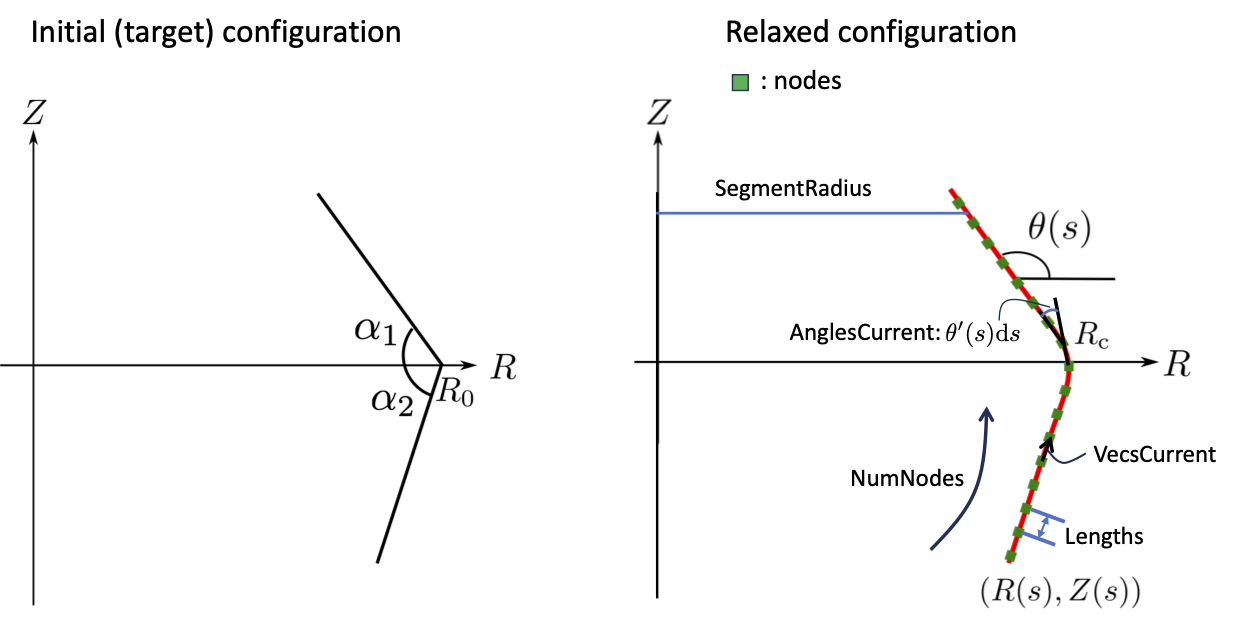

In [1]:
# 1D FEM simulation for the relaxed shape of intrisically curved folds
# SI Section 5B


import numpy as np
import math
from scipy import integrate
import time
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define the reference configuration
global Pi, NumNodes, t, R0, alpha1, alpha2, mu, length

Pi = math.pi
NumNodes = 200  # Number of nodes in 1D FEM

alpha1 = 0.3*Pi
alpha2 = 0.3*Pi
length = 1      # Length of each flank
R0 = 2          # Ridge radius
t = 0.01        # Thickness of the sheet
mu = 1          # Shear modulus


def fGeometry(NodePositionsR, NodePositionsZ):  # Compute the segment length, radius and area
    Lengths = np.zeros(NumNodes - 1)     # Segment length
    for i in range(0, NumNodes - 1):
        Lengths[i] = math.sqrt(                
            (NodePositionsR[i + 1] - NodePositionsR[i]) ** 2 + (NodePositionsZ[i + 1] - NodePositionsZ[i]) ** 2)
    SegmentRadius = np.zeros(NumNodes - 1)
    for i in range(0, NumNodes - 1):
        SegmentRadius[i] = (NodePositionsR[i + 1] + NodePositionsR[i]) / 2
    SegmentArea = np.zeros(NumNodes - 1)
    for i in range(0, NumNodes - 1):
        SegmentArea[i] = Pi * (NodePositionsR[i + 1] + NodePositionsR[i]) \
                         * math.sqrt((NodePositionsR[i + 1] - NodePositionsR[i]) ** 2
                                     + (NodePositionsZ[i + 1] - NodePositionsZ[i]) ** 2)
    return Lengths, SegmentRadius, SegmentArea


# Compute the stretch energy
def fStretchEnergy(LengthsCurrent, SegmentRadiusCurrent, SegmentAreaCurrent, LengthsTarget, SegmentRadiusTarget,
            SegmentAreaTarget, NodeLengthsTarget, NodeAreasTarget):

    # Stretch energy is computed by Eqs. [25] and [27] in the SI.
    StretchEnergy = 0.5 * mu * sum(SegmentAreaTarget * (
            (LengthsCurrent / LengthsTarget) ** 2 + (SegmentRadiusCurrent / SegmentRadiusTarget) ** 2 + \
        (LengthsTarget/LengthsCurrent )**2* (SegmentRadiusTarget/SegmentRadiusCurrent )**2 -3 ))  
    return StretchEnergy


# Compute the bend energy
def fBendEnergy(NodeCurrentPositionsR, NodeCurrentPositionsZ, LengthsCurrent, SegmentRadiusCurrent, SegmentAreaCurrent, LengthsTarget, SegmentRadiusTarget,
            SegmentAreaTarget, NodeLengthsTarget, NodeAreasTarget):
 
    NodeLengthsCurrent = np.zeros(NumNodes - 2)
    for i in range(0, NumNodes - 2):
        NodeLengthsCurrent[i] = (LengthsCurrent[i + 1] + LengthsCurrent[i]) / 2
    
    VecsCurrent = np.zeros((2, NumNodes - 1))
    for i in range(0, NumNodes - 1):
        VecsCurrent[0, i] = NodeCurrentPositionsR[i + 1] - NodeCurrentPositionsR[i]
        VecsCurrent[1, i] = NodeCurrentPositionsZ[i + 1] - NodeCurrentPositionsZ[i]
    NodeSinTheta = np.zeros(NumNodes - 2)
    for i in range(0, NumNodes - 2):
        NodeSinTheta[i] = (VecsCurrent[1,i] + VecsCurrent[1,i+1])/np.sqrt((VecsCurrent[1,i] + VecsCurrent[1,i+1])**2 + (VecsCurrent[0,i] + VecsCurrent[0,i+1])**2)
        
    AnglesCurrent = np.zeros(NumNodes - 2)
    for i in range(0, NumNodes - 2):
        cosAnglesCurrent = np.dot(VecsCurrent[:, i] / LengthsCurrent[i], VecsCurrent[:, i + 1] / LengthsCurrent[i + 1])
        if abs(cosAnglesCurrent) > 1:
            cosAnglesCurrent = np.sign(cosAnglesCurrent)
        AnglesCurrent[i] = math.acos(cosAnglesCurrent)
    
    # Bend energy is computed by Eqs. [26] and [28] in the SI.
    BendEnergy = 0
    for i in range(0, NumNodes - 2):
        BendEnergy = BendEnergy + 0.5 / 3 * mu * ((AnglesCurrent[i] / NodeLengthsTarget[i] * NodeLengthsCurrent[i]/NodeLengthsTarget[i]) ** 2
                                         + (NodeSinTheta[i] / NodeCurrentPositionsR[i + 1]) ** 2 + (AnglesCurrent[i] / NodeLengthsTarget[i] * NodeLengthsCurrent[i]/NodeLengthsTarget[i])*\
                                                  (NodeSinTheta[i] / NodeCurrentPositionsR[i + 1]) ) \
                     * NodeAreasTarget[i]
    return BendEnergy


# Compute the total elastic energy
def fEnergy(NodeCurrentPositions, LengthsTarget, SegmentRadiusTarget,
            SegmentAreaTarget, NodeLengthsTarget, NodeAreasTarget):
    
    NodeCurrentPositions[NumNodes+NumNodes//2-1] = 0  # Fix s=0 point at the coordiate y=0 to remove the y translation
    NodeCurrentPositionsR = NodeCurrentPositions[0: NumNodes]
    NodeCurrentPositionsZ = NodeCurrentPositions[NumNodes: NumNodes * 2]
    LengthsCurrent, SegmentRadiusCurrent, SegmentAreaCurrent = fGeometry(NodeCurrentPositionsR, NodeCurrentPositionsZ)  
    
    StretchEnergy = fStretchEnergy(LengthsCurrent, SegmentRadiusCurrent, SegmentAreaCurrent, LengthsTarget, SegmentRadiusTarget,
            SegmentAreaTarget, NodeLengthsTarget, NodeAreasTarget)
    BendEnergy = fBendEnergy(NodeCurrentPositionsR, NodeCurrentPositionsZ, LengthsCurrent, SegmentRadiusCurrent, SegmentAreaCurrent, LengthsTarget, SegmentRadiusTarget,
            SegmentAreaTarget, NodeLengthsTarget, NodeAreasTarget)
        
    TotalEnergy = 10000 * (t * StretchEnergy + t ** 3 * BendEnergy)
    return TotalEnergy


# Compute the intitial (target) geometry and energy
NodeInitPositionsR = np.zeros(NumNodes)
for i in range(1, NumNodes // 2 + 1):
    NodeInitPositionsR[i - 1] = R0 + length * (i - NumNodes / 2) / (NumNodes / 2 - 1) * math.cos(alpha2)
for i in range(NumNodes // 2 + 1, NumNodes + 1):
    NodeInitPositionsR[i - 1] = R0 - length * (i - NumNodes / 2) / (NumNodes / 2 - 1) * math.cos(alpha1)

NodeInitPositionsZ = np.zeros(NumNodes)
for i in range(1, NumNodes // 2 + 1):
    NodeInitPositionsZ[i - 1] = length * (i - (NumNodes / 2)) / (NumNodes / 2 - 1) * math.sin(alpha2)
for i in range(NumNodes // 2 + 1, NumNodes + 1):
    NodeInitPositionsZ[i - 1] = length * (i - (NumNodes / 2)) / (NumNodes / 2 - 1) * math.sin(alpha1)

LengthsTarget, SegmentRadiusTarget, SegmentAreaTarget = fGeometry(NodeInitPositionsR, NodeInitPositionsZ)
NodesS = np.zeros(NumNodes)
for i in range(1, NumNodes):
    NodesS[i] = NodesS[i - 1] + LengthsTarget[i - 1]
NodeLengthsTarget = np.zeros(NumNodes - 2)
for i in range(0, NumNodes - 2):
    NodeLengthsTarget[i] = (LengthsTarget[i + 1] + LengthsTarget[i]) / 2
NodeAreasTarget = np.zeros(NumNodes - 2)
for i in range(0, NumNodes - 2):
    NodeAreasTarget[i] = (SegmentAreaTarget[i + 1] + SegmentAreaTarget[i]) / 2

NodeInitPositions = np.hstack((NodeInitPositionsR, NodeInitPositionsZ))
initEnergy = fEnergy(NodeInitPositions, LengthsTarget, SegmentRadiusTarget,
                     SegmentAreaTarget, NodeLengthsTarget, NodeAreasTarget)


print("10000xInitial energy:", initEnergy)

10000xInitial energy: 3.290676538551529


10000xMinimized energy:  0.158258344867131
Simulation time: 676.1341950893402 seconds 


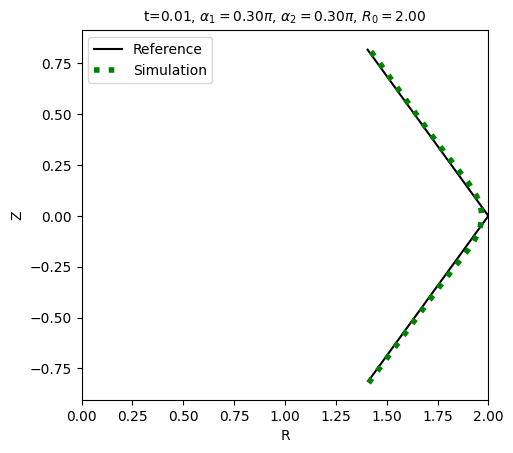

In [2]:
# SI Section 5B
# FEM energy minimization
# Plot 'FEM simulation vs reference configuration'

# optimization: BFGS returns the best approximation
import time
start_time=time.time()

fun = lambda x: fEnergy(x, LengthsTarget, SegmentRadiusTarget,
                        SegmentAreaTarget, NodeLengthsTarget, NodeAreasTarget)
results = minimize(fun,NodeInitPositions,method='BFGS')

print("10000xMinimized energy: ", results.fun)
print("Simulation time: %s seconds " % (time.time() - start_time))

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Plot the comparison between the reference configuration and the simulated relaxed configuration
fig1, ax = plt.subplots()

# Plot the reference shape

ax.set_aspect('1')
ax.plot(NodeInitPositionsR, NodeInitPositionsZ, color='black', linestyle='-',label='Reference')
ax.plot(-NodeInitPositionsR, NodeInitPositionsZ, color='black', linestyle='-')

# Plot the energy-minimizing shape
NodeOptimizedPositions = results.x
NodeOptimizedPositionsR = NodeOptimizedPositions[0: NumNodes]
NodeOptimizedPositionsZ = NodeOptimizedPositions[NumNodes: NumNodes * 2]

ax.plot(NodeOptimizedPositionsR, NodeOptimizedPositionsZ, color='g', linestyle='dotted',linewidth=4,label="Simulation")
ax.plot(-NodeOptimizedPositionsR, NodeOptimizedPositionsZ, color='g', linestyle='dotted',linewidth=4)

ax.set(xlabel="R",ylabel="Z",aspect='1')
ax.set_title(r't=%.2f, $\alpha_1=%.2f \pi$, $\alpha_2 = %.2f \pi$, $R_0=%.2f$'%(t,alpha1/Pi,alpha2/Pi,R0), fontsize='medium')
plt.xlim([0,R0])
plt.legend()
plt.show()

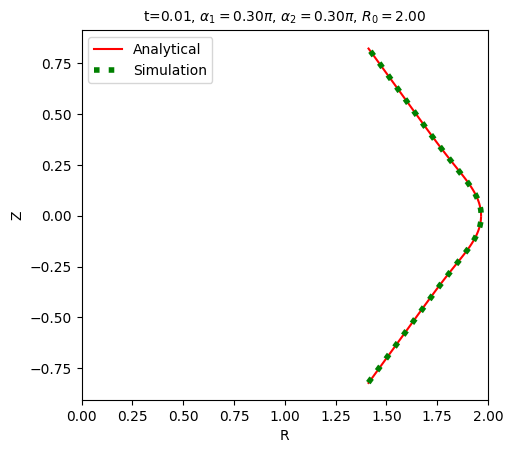

In [3]:
# SI Section 5C
# Analytical solution in (R, Z)
# Plot 'analystical solution vs simulation'

global cosAlpha1, cosAlpha2
cosAlpha1 = math.cos(alpha1)
cosAlpha2 = math.cos(alpha2)

D = 1/3*t ** 3*mu
Y = 3*t*mu
f = (4*R0**2 * D/Y)**(1/4)

def fDz1(s):  # s>0
    g1 = math.exp(-s / f)
    g3 = math.cos(s / f)
    dz1 = math.sqrt(1-(-cosAlpha1 + 1/2*g1*(cosAlpha1 + cosAlpha2)*g3)**2)
    return dz1

def fDz2(s):  # s<0
    g1 = math.exp(s / f)
    g3 = math.cos(s / f)
    dz2 = math.sqrt(1-(-cosAlpha2 + 1/2*g1*(cosAlpha1 + cosAlpha2)*g3)**2)
    return dz2

NumPoints = 201
s = np.linspace(-length, length, NumPoints)

r1 = np.zeros(NumPoints//2+1)
r2 = np.zeros(NumPoints//2)
z1 = np.zeros(NumPoints//2+1)
z2 = np.zeros(NumPoints//2)
dR = np.zeros(NumPoints)

for i in range(0, NumPoints):
    dR[i] = - f / 4 * math.exp(-abs(s[i]) / f)  \
          * (math.cos(alpha1) + math.cos(alpha2)) * (math.cos(s[i] / f) - math.sin(abs(s[i]) / f))
    
for i in range(0,NumPoints//2):
    r2[i] = R0 + s[i] * math.cos(alpha2) + dR[i]
    z2[i], err2 = integrate.quad(fDz2, 0, s[i])
    
for i in range(NumPoints//2, NumPoints):
    r1[i-NumPoints//2] = R0 - s[i] * math.cos(alpha1) + dR[i]
    z1[i-NumPoints//2], err1 = integrate.quad(fDz1, 0, s[i])
    
fig, ax = plt.subplots()
plt.plot(r1, z1, color='r', linestyle='-',label='Analytical')
plt.plot(r2, z2, color='r', linestyle='-')
plt.plot(-r1, z1, color='r', linestyle='-')
plt.plot(-r2, z2, color='r', linestyle='-')

ax.plot(NodeOptimizedPositionsR, NodeOptimizedPositionsZ, color='g', linestyle='dotted',linewidth=4,label="Simulation")
ax.plot(-NodeOptimizedPositionsR, NodeOptimizedPositionsZ, color='g', linestyle='dotted',linewidth=4)

ax.set_aspect('1')
ax.set(xlabel="R",ylabel="Z",aspect='1')
ax.set_title(r't=%.2f, $\alpha_1=%.2f \pi$, $\alpha_2 = %.2f \pi$, $R_0=%.2f$'%(t,alpha1/Pi,alpha2/Pi,R0), fontsize='medium')
plt.xlim([0,R0])
plt.legend()
plt.show()

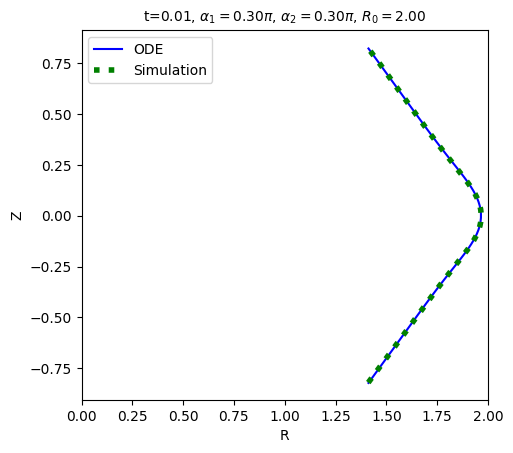

In [4]:
# SI Section 5D
# \theta(s) parameterization
# ODE solution vs FEM simulation

al1=alpha2 #alpha for s<0
al2=Pi-alpha1 #alpha for s>0
smin=-length #minimim s for integration
smax=length #max s for integration
D=1/3*mu*t**3
Y=3*mu*t

#make alpha into a function of s
def al(s):
    return al2 if s>0 else al1  

#make alpha into a function of s that takes an array of s values as an argument
def array_al(x):
    return np.array([al(xi) for xi in x])

def fun(s, th):
    return np.vstack((th[1],th[2],th[3], Y/D/R0**2 * (-np.cos(array_al(s)) + np.cos(th[0]))*np.sin(th[0]) + (th[2]**2 + 2*th[1]*th[3])/np.tan(th[0]) - 2*th[1]**2*th[2]/np.sin(th[0])**2 + th[1]*th[2]    ,np.cos(th[0]),np.sin(th[0])))

#tha and thb are evaluated at the two ends, smin and smax. These are the boundary conditions, th(smin)=al1, th'(smin)=0,R(smin)=Rref(smin),Z(smin=0),th(smax)=al2,th'(smax)=0
def bc(tha, thb):
    return np.array([tha[0]-al1,tha[1]-0, tha[4]-R0-smin*np.cos(al1),thb[5]-length*np.sin(al2)+tha[5] + length*np.sin(al1),thb[0]-al2,thb[1]-0])
                             


# Define the initial mesh from smin to smax with 50 nodes:

s = np.linspace(smin, smax, 50)

thguess = np.ones((6, s.size))
def theta0plus(s):
    return Pi-np.arctan((2*math.exp(s/f)*math.sqrt(1-1/4*math.exp(-((2*s)/f))*(-2*math.exp(s/f)*np.cos(alpha)+np.cos(s/f)*(np.cos(alpha)+np.cos(beta)))**2)/(2*math.exp(s/f)*np.cos(alpha)   \
                            -np.cos(s/f)*(np.cos(alpha)+np.cos(beta)))))

def theta0(s): 
    return theta0plus(s) if s>0 else Pi - theta0plus(-s)


def theta1plus(s):
    return (math.exp(-s/f)*(np.cos(alpha)+np.cos(beta))*(np.cos(s/f)+np.sin(s/f)))/(f*math.sqrt(math.exp(-2*s/f)*(4*math.exp(2*s/f)- \
        (-2*math.exp(s/f)+np.cos(s/f))**2*np.cos(alpha)**2-2*np.cos(s/f)*(-2*math.exp(s/f)+np.cos(s/f))*np.cos(alpha)*np.cos(beta)-np.cos(s/f)**2*np.cos(beta)**2)))
 
def theta1(s):
    return theta1plus(s) if s>0 else theta1plus(-s)
                                                 
def theta2plus(s):
    return ((np.cos(alpha)+np.cos(beta))*(2*math.exp(s/f)*np.cos(s/f)**2*np.cos(alpha)*(np.cos(alpha)+np.cos(beta))-np.cos(s/f)**3*(np.cos(alpha)+np.cos(beta))**2 \
            -np.cos(s/f)*(np.cos(alpha)+np.cos(beta))**2*np.sin(s/f)**2+2*math.exp(s/f)*np.sin(s/f)*(-4*math.exp(s/f)+np.cos(alpha)*np.cos(beta)*(-2*np.cos(s/f)+ \
        np.sin(s/f))+np.cos(alpha)**2*(4*math.exp(s/f)-2*np.cos(s/f)+np.sin(s/f)))))/(f**2*(4*math.exp(2*s/f)-(-2*math.exp(s/f)+np.cos(s/f))**2*np.cos(alpha)**2- \
            2*np.cos(s/f)*(-2*math.exp(s/f)+np.cos(s/f))*np.cos(alpha)*np.cos(beta)-np.cos(s/f)**2*np.cos(beta)**2)**(3/2))
def theta2(s):
    return theta2plus(s) if s>0 else -theta2plus(-s)

eps=10**(-8)                                             
def theta3plus(s):
    return (theta2plus(s+eps)-theta2plus(s))/eps
    
def theta3(s):
    return theta3plus(s) if s>0 else theta3plus(-s)


def radiusplus(s):
    return R-s*np.cos(alpha)-1/4*math.exp(-s/f)*f*(np.cos(alpha)+np.cos(beta))*(np.cos(s/f)-np.sin(s/f))
def radius(s):
    return radiusplus(s) if s>0 else radiusplus(-s)

def zplus(s):
    z1plus, err1 = integrate.quad(fDz1, 0, s)
    return z1plus
def zlength(s):
    return zplus(s) if s>0 else -zplus(-s)
                                                    
thguess = np.zeros((6, s.size))
thguess[0]=array_al(s)

# Solve the boundary value problem
from scipy.integrate import solve_bvp
res_a = solve_bvp(fun, bc, s, thguess)

%matplotlib inline

x_plot = np.linspace(smin, smax, 100)

fig, ax = plt.subplots()

x_plot = np.linspace(smin, smax, 100)
rs_a = res_a.sol(x_plot)[4]
zs_a = res_a.sol(x_plot)[5]- res_a.sol(0)[5]
ax.plot(rs_a, zs_a, label='ODE', color='b')
plt.plot(-rs_a, zs_a, color='b')

plt.plot(NodeOptimizedPositionsR, NodeOptimizedPositionsZ-NodeOptimizedPositionsZ[NumNodes//2-1], color='g', linestyle='dotted',label="Simulation",linewidth=4)
plt.plot(-NodeOptimizedPositionsR, NodeOptimizedPositionsZ-NodeOptimizedPositionsZ[NumNodes//2-1], color='g', linestyle='dotted',linewidth=4)

plt.xlabel("R")
plt.ylabel("Z")
ax.set_aspect('1')

legend = ax.legend(shadow=False)
ax.set(xlabel="R",ylabel="Z",aspect='1')
ax.set_title(r't=%.2f, $\alpha_1=%.2f \pi$, $\alpha_2 = %.2f \pi$, $R_0=%.2f$'%(t,alpha1/Pi,alpha2/Pi,R0), fontsize='medium')
plt.xlim([0,R0])
plt.show()



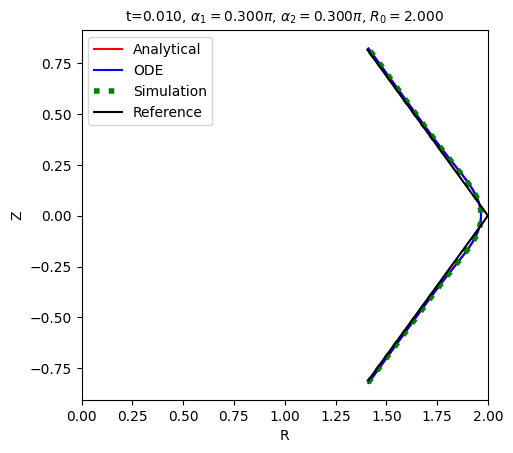

In [5]:
# Compare the FEM simulation, the analytical solution and the ODE solution

fig, ax = plt.subplots()
ax.plot(r1, z1, color='r', linestyle='-',label='Analytical')
ax.plot(r2, z2, color='r', linestyle='-')

ax.plot(rs_a, zs_a, label='ODE', color='b')

ax.plot(NodeOptimizedPositionsR, NodeOptimizedPositionsZ, color='g', linestyle='dotted',linewidth=4,label="Simulation")

ax.set_aspect('1')
ax.set(xlabel="R",ylabel="Z",aspect='1')
ax.set_title(r't=%.3f, $\alpha_1=%.3f \pi$, $\alpha_2 = %.3f \pi$, $R_0=%.3f$'%(t,alpha1/Pi,alpha2/Pi,R0), fontsize='medium')

ax.plot(NodeInitPositionsR, NodeInitPositionsZ, color='black', linestyle='-',label='Reference')
ax.plot(-NodeInitPositionsR, NodeInitPositionsZ, color='black', linestyle='-')

plt.xlim([0,R0])
plt.legend()
plt.show()

In [ ]:
# Compare the FEM simulation, the analytical solution and the ODE solution for the far-from-cylinder case: t=0.01, alpha1=alpha2=0.115\pi, R0=2.
# The ODE solution achieves a better accuracy in the far-from-cylinder case. 

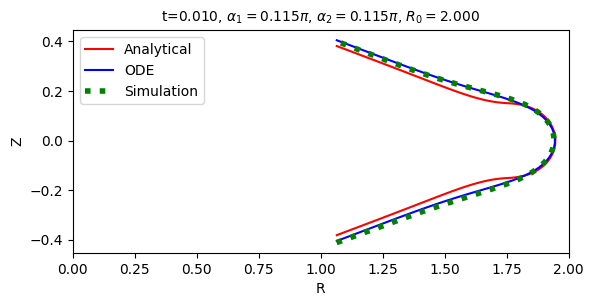